In [36]:
import os
import sys
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('default')
from spacepy import pycdf

from numpy import pi,sqrt,sin,cos,arcsin,arccos,dot,rad2deg,arctan,exp,cross
from scipy.special import erf
from tqdm import tqdm

from tletools import TLE
from scipy.interpolate import splrep,splev
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from scipy.signal import find_peaks
from scipy.special import iv
%matplotlib widget

In [2]:
days = mdates.DateLocator()   # date
daysFmt = mdates.DateFormatter('%d')
hoursFmt = mdates.DateFormatter('%H:%M')

In [3]:
start=dt.datetime(2011,9,25); stop=dt.datetime(2011,9,27);
sat='CNOFS'
alt_max = 796824.2289223758;
R_const = 8.31
k_B = 1.38 * (10**-23)
m_O=16; m_O2=32; m_N=14; m_N2=28; m_H=1; m_He=4;

R_O = (R_const/m_O)*1000;
R_N = (R_const/m_N)*1000;
R_O2 = (R_const/m_O2)*1000;
R_N2 = (R_const/m_N2)*1000;
R_He = (R_const/m_He)*1000;
R_H = (R_const/m_H)*1000;

m_cnofs = 384
m_p = 1.672e-27
sd = 28; qd = 13

In [4]:
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/EPB stuff/Data/OMNI Data/'
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\EPB stuff\\Data\\OMNI Data\\'
os.chdir(filepath)
filename = 'omni2_hourly_indices.txt';
SW_Data_hr = pd.DataFrame(np.loadtxt(filename,dtype = float));
time_array = [dt.datetime(int(SW_Data_hr.iloc[i,0]),1,1) + dt.timedelta(days = int(SW_Data_hr.iloc[i,1])-1) + dt.timedelta(hours=SW_Data_hr.iloc[i,2]) for i in range(len(SW_Data_hr))];
SW_Data_hr.index = pd.DatetimeIndex(time_array);
columns = ['Year','DOY','Hour','B0','Bx','By','Bz','Plasma Speed','Flow Pressure','Electric Field','Kp','R','Dst','AP','F107','AE','AL','AU'];
SW_Data_hr.columns = columns;

In [5]:
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/'
os.chdir(filepath)

filename = sat + '_IVM_' + start.strftime("%Y-%m-%d") + '.csv'
CNOFS_Data = pd.read_csv(filename)
CNOFS_Data.index = pd.DatetimeIndex(CNOFS_Data['Unnamed: 0'])
CNOFS_Data=CNOFS_Data.loc[start:stop]
CNOFS_Data = CNOFS_Data[CNOFS_Data.altitude < np.max(alt_max)/1000]

In [6]:
pks = find_peaks(CNOFS_Data['altitude'])[0]
trs = find_peaks(-CNOFS_Data['altitude'])[0]

In [7]:
idx_qd = [CNOFS_Data.index[trs[qd]],CNOFS_Data.index[pks[qd+1]]]
idx_sd = [CNOFS_Data.index[trs[sd]],CNOFS_Data.index[pks[sd+1]]]

(15242.5, 15244.0)

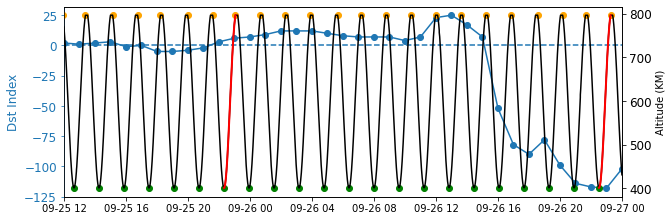

In [8]:
fig,ax1 = plt.subplots(figsize=[10,3.5])

ax1.plot(SW_Data_hr['Dst'].loc[start:stop],'-o',c='tab:blue')
ax1.spines['left'].set_color('tab:blue')
ax1.tick_params(axis='y',colors='tab:blue',labelsize=12)
ax1.axhline(y=0,ls='--',c='tab:blue')
ax1.set_ylabel('Dst Index',fontsize=12,c='tab:blue')
ax2 = ax1.twinx()
ax2.plot(CNOFS_Data['altitude'],c='k')
ax2.set_ylabel('Altitude (KM)',c='k')
ax2.spines['right'].set_color('k')
ax2.tick_params(axis='y',colors='k',labelsize=12)
for tr in trs:
    ax2.scatter(CNOFS_Data.index[tr],CNOFS_Data['altitude'][tr],c='green')
for pk in pks:
    ax2.scatter(CNOFS_Data.index[pk],CNOFS_Data['altitude'][pk],c='orange')
    
# ax2.axvline(x=CNOFS_Data.index[[sd],ls='--',c='r');ax2.axvline(x=orbit_end[sd+1],ls='--',c='k')
# ax2.axvline(x=orbit_end[qd],ls='--',c='r');ax2.axvline(x=orbit_end[qd+1],ls='--',c='k')

ax2.plot(CNOFS_Data['altitude'].loc[idx_qd[0]:idx_qd[1]],c='r',lw=2)
ax2.plot(CNOFS_Data['altitude'].loc[idx_sd[0]:idx_sd[1]],c='r',lw=2)
ax2.set_xlim([dt.datetime(2011,9,25,12,0,0),dt.datetime(2011,9,27,0,0,0)])


In [9]:
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\SPDF\\'
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/SPDF/'
os.chdir(filepath)
filename = 'cnofs_20230613194222_20713.cdf';
cdf = pycdf.CDF(filename)
time_array = pd.DatetimeIndex(cdf['Epoch'])
XYZ_TOD = pd.DataFrame(cdf['XYZ_TOD'],columns = ['X','Y','Z'],index = time_array)
XYZ_TOD = XYZ_TOD.loc[start:stop]
RADIUS = pd.DataFrame({'Radius' : list(cdf['RADIUS'])},index = time_array)


In [10]:
Z = XYZ_TOD['Z']
idxz = np.where(np.diff(np.sign(Z)) > 0)[0]
orbit_end = Z.index[idxz] 
time_avg = np.array([orbit_end[i] + (orbit_end[i+1] - orbit_end[i])/2 for i in range(len(orbit_end)-1)])

In [9]:
c=1/sqrt(2); c1=0.96592583; c2=0.25881905; c3=0.6830127;
theta = pi/10;
a = [0.636,0.636,0.636,0.636,0.636,0.636,0.636,0.636,
    0.579,0.579,0.579,0.579,0.579,0.579,0.579,0.579,
    0.142,0.142,0.142,0.142,0.142,0.142,0.142,0.142,
    0.047,0.047,0.047,0.047,0.047,0.047,0.047,0.047,0.047,0.047,
    0.455,1];
    # 0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,
    #  0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078, 
    #  0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,
    #  0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,0.1078,
    #  0.1056,0.1056,0.1056,0.1056,0.1056,0.1056,0.1056,0.1056,
    # 0.0924,0.0924,0.0924,0.0924,0.0924,0.0924,0.0924,0.0924];

n_a = [(1,0,0),(c,0,c),(0,0,1),(-c,0,c),(-1,0,0),(-c,0,-c),(0,0,-1),(c,0,-c),
      (1,0,0),(c,0,c),(0,0,1),(-c,0,c),(-1,0,0),(-c,0,-c),(0,0,-1),(c,0,-c),
      (c1,-c2,0),(c3,-c2,c3),(0,-c2,c1),(-c3,-c2,c3),(-c1,-c2,0),(-c3,-c2,-c3),(0,-c2,-c1),(c3,-c2,-c3),
      (cos(-theta),0,sin(-theta)),(cos(-3*theta),0,sin(-3*theta)),(cos(-5*theta),0,sin(-5*theta)),(cos(-7*theta),0,sin(-7*theta)),(cos(-9*theta),0,sin(-9*theta)),
      (cos(-11*theta),0,sin(-11*theta)),(cos(-13*theta),0,sin(-13*theta)),(cos(-15*theta),0,sin(-15*theta)),(cos(-17*theta),0,sin(-17*theta)),
       (cos(-19*theta),0,sin(-19*theta)),(0,-1,0),(0,1,0)];
      #  (0,1,0),(-0.5,c,0.5),(-c,0,c),(-0.5,-c,0.5),(0,-1,0),(0.5,-c,-0.5),(c,0,-c),(0.5,c,-0.5), ## boom 1
      #  (0,1,0),(-0.5,c,0.5),(-c,0,c),(-0.5,-c,0.5),(0,-1,0),(0.5,-c,-0.5),(c,0,-c),(0.5,c,-0.5), ## boom 2
      #  (0,1,0),(-0.5,c,-0.5),(-c,0,-c),(-0.5,-c,-0.5),(0,-1,0),(0.5,-c,0.5),(c,0,c),(0.5,c,0.5), ## boom 3
      #  (0,1,0),(-0.5,c,-0.5),(-c,0,-c),(-0.5,-c,-0.5),(0,-1,0),(0.5,-c,0.5),(c,0,c),(0.5,c,0.5), ## boom 4
      # (1,0,0),(c,0,c),(0,0,1),(-c,0,c),(-1,0,0),(-c,0,-c),(0,0,-1),(c,0,-c), ## boom 5
      # (1,0,0),(c,0,c),(0,0,1),(-c,0,c),(-1,0,0),(-c,0,-c),(0,0,-1),(c,0,-c)]; ## boom 6
        
def sigma_n(m_atm,m_s):
    ## m_atm = molecular mass of incident particle
    ## m_s = molecular mass of surface element
    mu = m_atm/m_s
    alpha = 3.0*mu/((1+mu)**2)
    alpha_n = 2*alpha - 1
    if alpha_n < 0:
        alpha_n = 0
    return 1 - sqrt(1-alpha_n)

def alpha(m_atm,m_s):
    ## m_atm = molecular mass of incident particle
    ## m_s = molecular mass of surface element
    mu = m_atm/m_s
    alpha = 3.0*mu/((1+mu)**2)
    return alpha

def theta(key,temp,nO):
    k_B = 1.38e-23
    P_O = nO*k_B*temp ## partial pressure of O
    if key == "DRIA":
        K = 1.44e6;        
    elif key == "CLL":
        K = 2.89e6;
    th = K*P_O/(1 + K*P_O)
    return th

def gamma1(x):
    return (1/(2*sqrt(pi)))*(exp(-x**2) + sqrt(pi)*x*(1+erf(x)))

def gamma2(x):
    return (1/(2*sqrt(pi)))*(x*exp(-x**2) + (sqrt(pi)/2)*(1 + 2*(x**2))*(1+erf(x)))

def C1(x):
    return (2*x**2 + 3)*iv(0,0.5*x**2) + (2*x**2 + 1)*iv(1,0.5*x**2)
def C2(x):
    return (x**2 + 1)*iv(0,0.5*x**2) + (x**2)*iv(1,0.5*x**2)

def drag_CLL_plane(v,R,temp,angle,sigma_t,sigma_n,T_s):
    ## angle = angle between surface normal and velocity vector
    s = v/sqrt(2*R*temp)
    v_w = sqrt(pi*R*T_s/2)
    g = cos(angle)
    mu = g*s 
    c1 = sigma_t*(1 - g**2)*gamma1(mu)
    c2 = (2-sigma_n)*g*gamma2(mu)/s
    c3 = sigma_n*(v_w/v)*gamma1(mu)*g
    return (2/s)*(c1+c2+c3)

def drag_CLL_sphere(v,R,temp,sigma_t,sigma_n,T_s):
    v_a = sqrt(2*R*temp);
    v_w = sqrt(pi*R*T_s/2);
    s = v/v_a
    p0 = (2 - sigma_n + sigma_t)/(2*(s**3))
    p1= (((4*(s**4)) + (4*(s**2)) - 1)*erf(s)/(2*s)) + ((2*s**2 + 1)*exp(-s**2)/sqrt(pi))
    p2 = (4/3)*sigma_n*(v_w/v) 
    return (p0*p1) + p2

def drag_CLL_cyl(v,R,temp,angle,sigma_t,sigma_n,T_s):
    ## angle = angle between cylindrical axis and velocity vector
    v_a = sqrt(2*R*temp);
    v_w = sqrt(pi*R*T_s/2);
    s = v/v_a
    g = sin(angle)
    mu = g*s
    p0 = (pi/2)*sigma_n*(v_w/v)*(g**2)
    p1 = (sqrt(pi)/(6*s))*(2*sigma_n - sigma_t - 4)*(g**2)*exp(-mu**2/2)*C1(mu)
    p2 = (sqrt(pi)*sigma_t/s)*(1 - g**2)*exp(-mu**2/2)*C2(mu)
    return p0 - p1 + p2

def drag_DRIA_plane(v,R,temp,angle,alpha,T_s):
    s = v/sqrt(2*R*temp)
    g=cos(angle)
    mu = g*s
    P = exp(-mu**2)/s
    Q = 1 + 1/(2*(s**2))
    Z = 1 + erf(g*s)
    ratio = sqrt((2/3)*(1 + alpha*((3*R*T_s/(v**2))-1)))
    C_D = (P/sqrt(pi)) + (g*Q*Z) + ((g/2)*ratio*((g*sqrt(pi)*Z) + P))
    return C_D

def drag_DRIA_sphere(v,R,temp,alpha,T_s):
    s = v/sqrt(2*R*temp)
    ratio = sqrt((2/3)*(1 + alpha*((3*R*T_s/(v**2))-1)))
    p0 = (2*s**2 + 1)*exp(-s**2)/(sqrt(pi) * s**3)
    p1 = (4*s**4 + 4*s**2 - 1)*erf(s)/(2 * s**4)
    p2 = (2*sqrt(pi)/3)*ratio
    return p0 + p1 + p2

def drag_DRIA_cyl(v,R,temp,angle,alpha,T_s):
    s = v/sqrt(2*R*temp)
    g=sin(angle)
    mu = g*s
    ratio = sqrt((2/3)*(1 + alpha*((3*R*T_s/(v**2))-1)))
    p0 = s*sqrt(pi)*(g**2)*(1 + 1/(2 * s**2))*exp(-mu**2/2)*(iv(0,mu**2/2) + iv(1,mu**2/2))
    p1 = (sqrt(pi)/s)*exp(-mu**2/2)*iv(0,mu**2/2)
    p2 = (pi**1.5)*(g**2)*ratio/4
    return p0+p1+p2

def CNOFS_area(v,a,n_a):
    area=0;r_probe = 0.06; r_boom = 0.0143;
    v_abs = sqrt(v[0]**2 + v[1]**2 + v[2]**2)
    v_unit = v/v_abs
    for i,n in enumerate(n_a):
        angle = arccos(dot(v_unit,n))
        if angle < pi/2:
            area = area + a[i]*cos(angle)
    area += 1.3259 ## booms and probes added
    return area

def drag_CNOFS_CLL(v,R,temp,m_atm,nO,T_s,a,n_a):
    r_probe = 0.06; r_boom = 0.0143;
    sn = sigma_n(m_atm,60)
    th = theta("CLL",temp,nO)
    v_abs = sqrt(v[0]**2 + v[1]**2 + v[2]**2)
    v_unit = v/v_abs
    CD_CO = 0; CD_CL = 0;
    for i,n in enumerate(n_a):
        angle = arccos(dot(v_unit,n))
        CD_CO += drag_CLL_plane(v_abs,R,temp,angle,1,1,T_s)*a[i]
        CD_CL += drag_CLL_plane(v_abs,R,temp,angle,1,sn,T_s)*a[i]
    
    CD_CO += 4*drag_CLL_cyl(v_abs,R,temp,pi/4,1,1,T_s)*2*r_boom*(9.8-0.61)
    CD_CL += 4*drag_CLL_cyl(v_abs,R,temp,pi/4,1,sn,T_s)*2*r_boom*(9.8-0.61)
    
    CD_CO += drag_CLL_cyl(v_abs,R,temp,pi/2,1,1,T_s)*2*r_boom*18.02
    CD_CL += drag_CLL_cyl(v_abs,R,temp,pi/2,1,sn,T_s)*2*r_boom*18.02
    
    CD_CO += (6*drag_CLL_sphere(v_abs,R,temp,1,1,T_s)*(pi*(r_probe**2)))
    CD_CL += (6*drag_CLL_sphere(v_abs,R,temp,1,sn,T_s)*(pi*(r_probe**2)))
    
    area = CNOFS_area(v,a,n_a);
    C_D = (th*CD_CO + (1-th)*CD_CL)/area
    return C_D
    
def drag_CNOFS_DRIA(v,R,temp,m_atm,nO,T_s,a,n_a):
    r_probe = 0.06; r_boom = 0.0143;
    alpha_ads = 1.0;
    alpha_s = alpha(m_atm,60)
    th = theta("DRIA",temp,nO)
    v_abs = sqrt(v[0]**2 + v[1]**2 + v[2]**2)
    v_unit = v/v_abs
    CD_CO = 0; CD_CL = 0;
    for i,n in enumerate(n_a):
        angle = arccos(dot(v_unit,n))
        CD_CO += drag_DRIA_plane(v_abs,R,temp,angle,alpha_ads,T_s)*a[i]
        CD_CL += drag_DRIA_plane(v_abs,R,temp,angle,alpha_s,T_s)*a[i]
    
    CD_CO += 4*drag_DRIA_cyl(v_abs,R,temp,pi/4,alpha_ads,T_s)*2*r_boom*(9.8-0.61)
    CD_CL += 4*drag_DRIA_cyl(v_abs,R,temp,pi/4,alpha_s,T_s)*2*r_boom*(9.8-0.61)
    
    CD_CO += drag_DRIA_cyl(v_abs,R,temp,pi/2,alpha_ads,T_s)*2*r_boom*18.02
    CD_CL += drag_DRIA_cyl(v_abs,R,temp,pi/2,alpha_s,T_s)*2*r_boom*18.02
    
    CD_CO += (6*drag_DRIA_sphere(v_abs,R,temp,alpha_ads,T_s)*(pi*(r_probe**2)))
    CD_CL += (6*drag_DRIA_sphere(v_abs,R,temp,alpha_s,T_s)*(pi*(r_probe**2)))
    
    area = CNOFS_area(v,a,n_a);
    C_D = (th*CD_CO + (1-th)*CD_CL)/area
    return C_D

In [10]:
# c=1/sqrt(2); c1=0.96592583; c2=0.25881905; c3=0.6830127;
# theta = pi/10;
# a = [0.636,0.636,0.636,0.636,0.636,0.636,0.636,0.636,
#     0.579,0.579,0.579,0.579,0.579,0.579,0.579,0.579,
#     0.142,0.142,0.142,0.142,0.142,0.142,0.142,0.142,
#     0.047,0.047,0.047,0.047,0.047,0.047,0.047,0.047,0.047,0.047,
#     0.455,1]
# n_a = [(1,0,0),(c,0,c),(0,0,1),(-c,0,c),(-1,0,0),(-c,0,-c),(0,0,-1),(c,0,-c),
#       (1,0,0),(c,0,c),(0,0,1),(-c,0,c),(-1,0,0),(-c,0,-c),(0,0,-1),(c,0,-c),
#       (c1,-c2,0),(c3,-c2,c3),(0,-c2,c1),(-c3,-c2,c3),(-c1,-c2,0),(-c3,-c2,-c3),(0,-c2,-c1),(c3,-c2,-c3),
#       (cos(-theta),0,sin(-theta)),(cos(-3*theta),0,sin(-3*theta)),(cos(-5*theta),0,sin(-5*theta)),(cos(-7*theta),0,sin(-7*theta)),(cos(-9*theta),0,sin(-9*theta)),
#       (cos(-11*theta),0,sin(-11*theta)),(cos(-13*theta),0,sin(-13*theta)),(cos(-15*theta),0,sin(-15*theta)),(cos(-17*theta),0,sin(-17*theta)),
#        (cos(-19*theta),0,sin(-19*theta)),(0,-1,0),(0,1,0)]

# def sigma_n(m_atm,m_s):
#     ## m_atm = molecular mass of incident particle
#     ## m_s = molecular mass of surface element
#     mu = m_atm/m_s
#     alpha = 3.0*mu/((1+mu)**2)
#     alpha_n = 2*alpha - 1
#     if alpha_n < 0:
#         alpha_n = 0
#     return 1 - sqrt(1-alpha_n)

# def alpha(m_atm,m_s):
#     ## m_atm = molecular mass of incident particle
#     ## m_s = molecular mass of surface element
#     mu = m_atm/m_s
#     alpha = 3.0*mu/((1+mu)**2)
#     return alpha

# def theta(key,R,temp,nO):
#     k_B = 1.38e-23
#     P_O = nO*k_B*temp ## partial pressure of O
#     if key == "DRIA":
#         K = 1.44e6;        
#     elif key == "CLL":
#         K = 2.89e6;
#     th = K*P_O/(1 + K*P_O)
#     return th

# def gamma1(x):
#     return (1/(2*sqrt(pi)))*(exp(-x**2) + sqrt(pi)*x*(1+erf(x)))

# def gamma2(x):
#     return (1/(2*sqrt(pi)))*(x*exp(-x**2) + (sqrt(pi)/2)*(1 + 2*(x**2))*(1+erf(x)))

# def C1(x):
#     return (2*x**2 + 3)*iv(0,0.5*x**2) + (2*x**2 + 1)*iv(1,0.5*x**2)
# def C2(x):
#     return (x**2 + 1)*iv(0,0.5*x**2) + (x**2)*iv(1,0.5*x**2)

# def drag_CLL_plane(v,R,temp,angle,sigma_t,sigma_n,T_s):
#     ## angle = angle between surface normal and velocity vector
#     s = v/sqrt(2*R*temp)
#     v_w = sqrt(pi*R*T_s/2)
#     g = cos(angle)
#     mu = g*s 
#     c1 = sigma_t*(1 - g**2)*gamma1(mu)
#     c2 = (2-sigma_n)*g*gamma2(mu)/s
#     c3 = sigma_n*(v_w/v)*gamma1(mu)*g
#     return (2/s)*(c1+c2+c3)

# def drag_CLL_sphere(v,R,temp,sigma_t,sigma_n,T_s):
#     v_a = sqrt(2*R*temp);
#     v_w = sqrt(pi*R*T_s/2);
#     s = v/v_a
#     p0 = (2 - sigma_n + sigma_t)/(2*(s**3))
#     p1= (((4*(s**4)) + (4*(s**2)) - 1)*erf(s)/(2*s)) + ((2*s**2 + 1)*exp(-s**2)/sqrt(pi))
#     p2 = (4/3)*sigma_n*(v_w/v) 
#     return (p0*p1) + p2

# def drag_CLL_cyl(v,R,temp,angle,sigma_t,sigma_n,T_s):
#     ## angle = angle between cylindrical axis and velocity vector
#     v_a = sqrt(2*R*temp);
#     v_w = sqrt(pi*R*T_s/2);
#     s = v/v_a
#     g = sin(angle)
#     mu = g*s
#     p0 = (pi/2)*sigma_n*(v_w/v)*(g**2)
#     p1 = (sqrt(pi)/(6*s))*(2*sigma_n - sigma_t - 4)*(g**2)*exp(-mu**2/2)*C1(mu)
#     p2 = (sqrt(pi)*sigma_t/s)*(1 - g**2)*exp(-mu**2/2)*C2(mu)
#     return p0 - p1 + p2

# def drag_DRIA_plane(v,R,temp,angle,alpha,T_s):
#     s = v/sqrt(2*R*temp)
#     g=cos(angle)
#     mu = g*s
#     P = exp(-mu**2)/s
#     Q = 1 + 1/(2*(s**2))
#     Z = 1 + erf(g*s)
#     ratio = sqrt((2/3)*(1 + alpha*((3*R*T_s/(v**2))-1)))
#     C_D = (P/sqrt(pi)) + (g*Q*Z) + ((g/2)*ratio*((g*sqrt(pi)*Z) + P))
#     return C_D

# def drag_DRIA_sphere(v,R,temp,alpha,T_s):
#     s = v/sqrt(2*R*temp)
#     ratio = sqrt((2/3)*(1 + alpha*((3*R*T_s/(v**2))-1)))
#     p0 = (2*s**2 + 1)*exp(-s**2)/(sqrt(pi) * s**3)
#     p1 = (4*s**4 + 4*s**2 - 1)*erf(s)/(2 * s**4)
#     p2 = (2*sqrt(pi)/3)*ratio
#     return p0 + p1 + p2

# def drag_DRIA_cyl(v,R,temp,angle,alpha,T_s):
#     s = v/sqrt(2*R*temp)
#     g=sin(angle)
#     mu = g*s
#     ratio = sqrt((2/3)*(1 + alpha*((3*R*T_s/(v**2))-1)))
#     p0 = s*sqrt(pi)*(g**2)*(1 + 1/(2 * s**2))*exp(-mu**2/2)*(iv(0,mu**2/2) + iv(1,mu**2/2))
#     p1 = (sqrt(pi)/s)*exp(-mu**2/2)*iv(0,mu**2/2)
#     p2 = (pi**1.5)*(g**2)*ratio/4
#     return p0+p1+p2

# def CNOFS_area(v,a,n_a):
#     area=0;r_probe = 0.06; r_boom = 0.0143;
#     v_abs = sqrt(v[0]**2 + v[1]**2 + v[2]**2)
#     v_unit = v/v_abs
#     for i,n in enumerate(n_a):
#         angle = arccos(dot(v_unit,n))
#         if angle < pi/2:
#             area = area + a[i]*cos(angle)
#     area += 1.3259
#     return area

# def drag_CNOFS_CLL(v,R,temp,m_atm,nO,T_s,a,n_a):
#     r_probe = 0.06; r_boom = 0.0143;
#     sn = sigma_n(m_atm,60)
#     th = theta("CLL",R,temp,nO)
#     v_abs = sqrt(v[0]**2 + v[1]**2 + v[2]**2)
#     v_unit = v/v_abs
#     CD_CO = 0; CD_CL = 0;
#     for i,n in enumerate(n_a):
#         angle = arccos(dot(v_unit,n))
#         CD_CO += drag_CLL_plane(v_abs,R,temp,angle,1,1,T_s)*a[i]
#         CD_CL += drag_CLL_plane(v_abs,R,temp,angle,1,sn,T_s)*a[i]
    
#     CD_CO += 4*drag_CLL_cyl(v_abs,R,temp,pi/4,1,1,T_s)*2*r_boom*(9.8-0.61)
#     CD_CL += 4*drag_CLL_cyl(v_abs,R,temp,pi/4,1,sn,T_s)*2*r_boom*(9.8-0.61)
    
#     CD_CO += drag_CLL_cyl(v_abs,R,temp,pi/2,1,1,T_s)*2*r_boom*18.02
#     CD_CL += drag_CLL_cyl(v_abs,R,temp,pi/2,1,sn,T_s)*2*r_boom*18.02
    
#     CD_CO += (6*drag_CLL_sphere(v_abs,R,temp,1,1,T_s)*(pi*(r_probe**2)))
#     CD_CL += (6*drag_CLL_sphere(v_abs,R,temp,1,sn,T_s)*(pi*(r_probe**2)))
    
#     area = CNOFS_area(v,a,n_a);
#     C_D = (th*CD_CO + (1-th)*CD_CL)/area
#     return C_D
    
# def drag_CNOFS_DRIA(v,R,temp,m_atm,nO,T_s,a,n_a):
#     r_probe = 0.06; r_boom = 0.0143;
#     alpha_ads = 1.0;
#     alpha_s = alpha(m_atm,60)
#     th = theta("DRIA",R,temp,nO)
#     v_abs = sqrt(v[0]**2 + v[1]**2 + v[2]**2)
#     v_unit = v/v_abs
#     CD_CO = 0; CD_CL = 0;
#     for i,n in enumerate(n_a):
#         angle = arccos(dot(v_unit,n))
#         CD_CO += drag_DRIA_plane(v_abs,R,temp,angle,alpha_ads,T_s)*a[i]
#         CD_CL += drag_DRIA_plane(v_abs,R,temp,angle,alpha_s,T_s)*a[i]
    
#     CD_CO += 4*drag_DRIA_cyl(v_abs,R,temp,pi/4,alpha_ads,T_s)*2*r_boom*(9.8-0.61)
#     CD_CL += 4*drag_DRIA_cyl(v_abs,R,temp,pi/4,alpha_s,T_s)*2*r_boom*(9.8-0.61)
    
#     CD_CO += drag_DRIA_cyl(v_abs,R,temp,pi/2,alpha_ads,T_s)*2*r_boom*18.02
#     CD_CL += drag_DRIA_cyl(v_abs,R,temp,pi/2,alpha_s,T_s)*2*r_boom*18.02
    
#     CD_CO += (6*drag_DRIA_sphere(v_abs,R,temp,alpha_ads,T_s)*(pi*(r_probe**2)))
#     CD_CL += (6*drag_DRIA_sphere(v_abs,R,temp,alpha_s,T_s)*(pi*(r_probe**2)))
    
#     area = CNOFS_area(v,a,n_a);
#     C_D = (th*CD_CO + (1-th)*CD_CL)/area
#     return C_D

In [11]:
V = np.array(list(zip(CNOFS_Data['scRELvelocityX']*1000,CNOFS_Data['scRELvelocityY']*1000,CNOFS_Data['scRELvelocityZ']*1000)))
area = np.array([CNOFS_area(v,a,n_a) for v in V])

## MSIS

In [14]:
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\';
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/';
os.chdir(filepath)
Data_MSIS = pd.read_csv(sat+'_MSIS_jl_'+start.strftime("%Y-%m-%d")+'.csv')
Data_MSIS.index=pd.DatetimeIndex(Data_MSIS['Unnamed: 0'])
Data_MSIS = Data_MSIS.loc[start:stop]
Data_MSIS_orbit = [Data_MSIS['rho'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)] 

NameError: name 'Data_GITM_orbit' is not defined

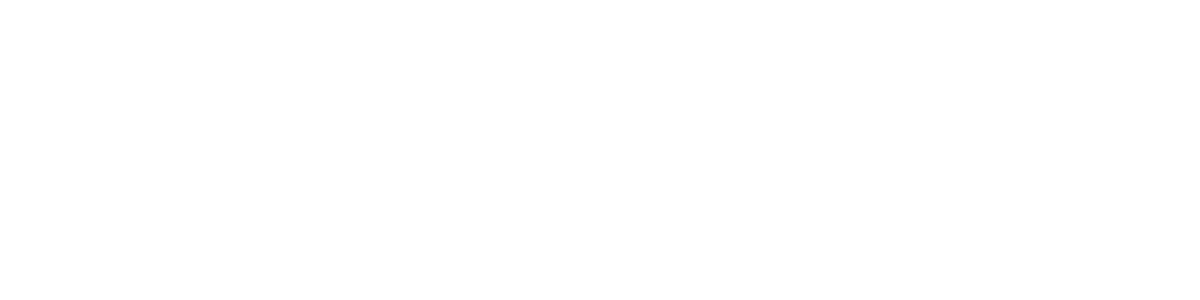

In [15]:
plt.figure(figsize=[12,3])
plt.plot(time_avg,Data_GITM_orbit,'-o')
plt.plot(time_avg,Data_MSIS_orbit,'-o',c='tab:Red')
plt.yscale('linear')

In [ ]:
mole_frac = pd.DataFrame({'O':[Data_MSIS['nO'][i]/sum(Data_MSIS.iloc[i,2:8]) for i in tqdm(range(len(Data_MSIS)))],
                          'N':[Data_MSIS['nN'][i]/sum(Data_MSIS.iloc[i,2:8]) for i in tqdm(range(len(Data_MSIS)))],
                         'O2':[Data_MSIS['nO2'][i]/sum(Data_MSIS.iloc[i,2:8]) for i in tqdm(range(len(Data_MSIS)))],
                          'N2': [Data_MSIS['nN2'][i]/sum(Data_MSIS.iloc[i,2:8]) for i in tqdm(range(len(Data_MSIS)))],
                          'He': [Data_MSIS['nHe'][i]/sum(Data_MSIS.iloc[i,2:8]) for i in tqdm(range(len(Data_MSIS)))],
                          'H': [Data_MSIS['nH'][i]/sum(Data_MSIS.iloc[i,2:8]) for i in tqdm(range(len(Data_MSIS)))],
                         },index = Data_MSIS.index);
mole_frac_msis = mole_frac

In [ ]:
m_avg = m_O*mole_frac['O'] + m_O2*mole_frac['O2']+m_N*mole_frac['N'] + m_N2*mole_frac['N2'] + m_He*mole_frac['He'] + m_H*mole_frac['H']

In [ ]:
idx_qd = np.arange(trs[qd],pks[qd+1],1);
idx_sd = np.arange(trs[sd],pks[sd+1],1);

In [ ]:
C_D = [];Area = []; alpha= []; 
for idx0 in tqdm(idx_qd):
    v = V[idx0];
    temp = Data_MSIS['Tz'][idx0];
    m_atm = m_avg[idx0];
    nO = Data_MSIS['nO'][idx0];
    T_s = 300;
    CD_O = drag_CNOFS_CLL(v,R_O,temp,m_atm,nO,T_s,a,n_a)*m_O*mole_frac['O'][idx0]
    CD_O2= drag_CNOFS_CLL(v,R_O2,temp,m_atm,nO,T_s,a,n_a)*m_O2*mole_frac['O2'][idx0]
    CD_N= drag_CNOFS_CLL(v,R_N,temp,m_atm,nO,T_s,a,n_a)*m_N*mole_frac['N'][idx0]
    CD_N2= drag_CNOFS_CLL(v,R_N2,temp,m_atm,nO,T_s,a,n_a)*m_N2*mole_frac['N2'][idx0]
    CD_He= drag_CNOFS_CLL(v,R_He,temp,m_atm,nO,T_s,a,n_a)*m_He*mole_frac['He'][idx0]
    CD_H= drag_CNOFS_CLL(v,R_H,temp,m_atm,nO,T_s,a,n_a)*m_H*mole_frac['H'][idx0]
    C_D.append((CD_O+CD_O2+CD_N+CD_N2+CD_H+CD_He)/m_atm)
    alpha_n = 
    
CD_MSIS_CLL_qd=pd.DataFrame({"C_D":C_D,'A':area[idx_qd]},index=CNOFS_Data.index[idx_qd])


In [ ]:
C_D = [];Area = [];alpha=[];
for idx0 in tqdm(idx_sd):
    v = V[idx0];
    temp = Data_MSIS['Tz'][idx0];
    m_atm = m_avg[idx0];
    nO = Data_MSIS['nO'][idx0];
    T_s = 300;
    CD_O = drag_CNOFS_CLL(v,R_O,temp,m_atm,nO,T_s,a,n_a)*m_O*mole_frac['O'][idx0]
    CD_O2= drag_CNOFS_CLL(v,R_O2,temp,m_atm,nO,T_s,a,n_a)*m_O2*mole_frac['O2'][idx0]
    CD_N= drag_CNOFS_CLL(v,R_N,temp,m_atm,nO,T_s,a,n_a)*m_N*mole_frac['N'][idx0]
    CD_N2= drag_CNOFS_CLL(v,R_N2,temp,m_atm,nO,T_s,a,n_a)*m_N2*mole_frac['N2'][idx0]
    CD_He= drag_CNOFS_CLL(v,R_He,temp,m_atm,nO,T_s,a,n_a)*m_He*mole_frac['He'][idx0]
    CD_H= drag_CNOFS_CLL(v,R_H,temp,m_atm,nO,T_s,a,n_a)*m_H*mole_frac['H'][idx0]
    C_D.append((CD_O+CD_O2+CD_N+CD_N2+CD_H+CD_He)/m_atm)
    alpha_s = 
CD_MSIS_CLL_sd=pd.DataFrame({"C_D":C_D,'A':area[idx_sd]},index=CNOFS_Data.index[idx_sd])

In [ ]:
fig,ax = plt.subplots(3,1,figsize=[10,6],sharex=True)
ax[0].plot(CNOFS_Data['altitude'][idx_qd],mole_frac['O'][idx_qd],label='quiet-time')
ax[0].plot(CNOFS_Data['altitude'][idx_sd],mole_frac['O'][idx_sd],label='storm-time')
ax[0].set_ylabel('O mole fraction')
ax[0].legend()

ax[1].plot(CNOFS_Data['altitude'][idx_qd],Data_MSIS['Tz'][idx_qd],label='quiet-time')
ax[1].plot(CNOFS_Data['altitude'][idx_sd],Data_MSIS['Tz'][idx_sd],label='storm-time')
ax[1].set_ylabel('Temperature')
ax[1].legend()

ax[2].plot(CNOFS_Data['altitude'][idx_qd],CD_MSIS_CLL_qd['C_D'],label='quiet-time')
ax[2].plot(CNOFS_Data['altitude'][idx_sd],CD_MSIS_CLL_sd['C_D'],label='storm-time')
ax[2].set_ylabel('C_D')
ax[2].legend()


## GITM

In [12]:
df_qd = CNOFS_Data.loc[idx_qd[0]:idx_qd[1]]
df_sd = CNOFS_Data.loc[idx_sd[0]:idx_sd[1]]

In [13]:
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\';
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/';
os.chdir(filepath)
Data_GITM_qd = pd.read_csv('CNOFS_gitm_out_qd_LNI_sep_2011.csv')
Data_GITM_qd.index=pd.DatetimeIndex(Data_GITM_qd['Unnamed: 0'])
# Data_GITM_qd = Data_GITM_qd.loc[start:stop]
Data_GITM_qd = Data_GITM_qd.drop(columns='Unnamed: 0')


In [14]:
filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\';
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/Temp/';
os.chdir(filepath)
Data_GITM_sd = pd.read_csv('CNOFS_gitm_out_sd_LNI_sep_2011.csv')
Data_GITM_sd.index=pd.DatetimeIndex(Data_GITM_sd['Unnamed: 0'])
# Data_GITM_sd = Data_GITM_sd.loc[start:stop]
Data_GITM_sd = Data_GITM_sd.drop(columns='Unnamed: 0')

In [17]:
# T1 = (Data_GITM_qd.index - start)/dt.timedelta(seconds=1)
# T2 = (df_qd.index - start)/dt.timedelta(seconds=1)
# Data_GITM_qd_int = pd.DataFrame()
# for col in Data_GITM_qd.columns:
#     tck = splrep(T1,Data_GITM_qd[col],k=3)
#     Data_GITM_qd_int[col] = splev(T2,tck)
# Data_GITM_qd_int.index = df_qd.index

In [18]:
# T1 = (Data_GITM_sd.index - start)/dt.timedelta(seconds=1)
# T2 = (df_sd.index - start)/dt.timedelta(seconds=1)
# Data_GITM_sd_int = pd.DataFrame()
# for col in Data_GITM_sd.columns:
#     tck = splrep(T1,Data_GITM_sd[col],k=3)
#     Data_GITM_sd_int[col] = splev(T2,tck)
# Data_GITM_sd_int.index = df_sd.index

## quiet day

In [15]:
nO = Data_GITM_qd['O(!U3!NP)'] + Data_GITM_qd['O(!U1!ND)'] 
nO2 = Data_GITM_qd['O!D2!N']
nN = Data_GITM_qd['N(!U2!ND)'] + Data_GITM_qd['N(!U2!NP)'] + Data_GITM_qd['N(!U4!NS)']
nN2 = Data_GITM_qd['N!D2!N']
nHe = Data_GITM_qd['He']
nH = Data_GITM_qd['H']
ntot = nO+nO2+nN+nN2+nHe+nH
mole_frac = pd.DataFrame({'O':nO/ntot,'O2':nO2/ntot,'N':nN/ntot,'N2':nN2/ntot,'He':nHe/ntot,'H':nH/ntot},
            index=Data_GITM_qd.index)
m_avg = m_O*mole_frac['O'] + m_O2*mole_frac['O2']+m_N*mole_frac['N'] + m_N2*mole_frac['N2'] + m_He*mole_frac['He'] + m_H*mole_frac['H']
mole_frac_gitm_qd = mole_frac
O_dens_qd = nO


In [16]:
V = np.array(list(zip(df_qd['scRELvelocityX']*1000,df_qd['scRELvelocityY']*1000,df_qd['scRELvelocityZ']*1000)))
area = np.array([CNOFS_area(v,a,n_a) for v in V])

In [17]:
C_D = [];
for idx0 in tqdm(range(len(df_qd))):
    v = [np.sqrt(np.sum(V[idx0]**2)),0,0];
    temp = Data_GITM_qd['Temperature'][idx0];
    m_atm = m_avg[idx0];
    n_O = nO[idx0];
    T_s = 300;
    CD_O = drag_CNOFS_CLL(v,R_O,temp,m_atm,n_O,T_s,a,n_a)*m_O*mole_frac_gitm_qd['O'][idx0]
    CD_O2= drag_CNOFS_CLL(v,R_O2,temp,m_atm,n_O,T_s,a,n_a)*m_O2*mole_frac_gitm_qd['O2'][idx0]
    CD_N= drag_CNOFS_CLL(v,R_N,temp,m_atm,n_O,T_s,a,n_a)*m_N*mole_frac_gitm_qd['N'][idx0]
    CD_N2= drag_CNOFS_CLL(v,R_N2,temp,m_atm,n_O,T_s,a,n_a)*m_N2*mole_frac_gitm_qd['N2'][idx0]
    CD_He= drag_CNOFS_CLL(v,R_He,temp,m_atm,n_O,T_s,a,n_a)*m_He*mole_frac_gitm_qd['He'][idx0]
    CD_H= drag_CNOFS_CLL(v,R_H,temp,m_atm,n_O,T_s,a,n_a)*m_H*mole_frac_gitm_qd['H'][idx0]
    C_D.append((CD_O+CD_O2+CD_N+CD_N2+CD_H+CD_He)/m_atm)
CD_GITM_CLL_qd=pd.DataFrame({"C_D":C_D,'A':area},index=df_qd.index)


100%|████████████████████████████████████████████████████████████████████████████████| 533/533 [00:08<00:00, 60.39it/s]


In [18]:
C_D = [];
for idx0 in tqdm(range(len(df_qd))):
    v = [np.sqrt(np.sum(V[idx0]**2)),0,0];
    temp = Data_GITM_qd['Temperature'][idx0];
    m_atm = m_avg[idx0];
    n_O = nO[idx0];
    T_s = 300;
    CD_O = drag_CNOFS_DRIA(v,R_O,temp,m_atm,n_O,T_s,a,n_a)*m_O*mole_frac_gitm_qd['O'][idx0]
    CD_O2= drag_CNOFS_DRIA(v,R_O2,temp,m_atm,n_O,T_s,a,n_a)*m_O2*mole_frac_gitm_qd['O2'][idx0]
    CD_N= drag_CNOFS_DRIA(v,R_N,temp,m_atm,n_O,T_s,a,n_a)*m_N*mole_frac_gitm_qd['N'][idx0]
    CD_N2= drag_CNOFS_DRIA(v,R_N2,temp,m_atm,n_O,T_s,a,n_a)*m_N2*mole_frac_gitm_qd['N2'][idx0]
    CD_He= drag_CNOFS_DRIA(v,R_He,temp,m_atm,n_O,T_s,a,n_a)*m_He*mole_frac_gitm_qd['He'][idx0]
    CD_H= drag_CNOFS_DRIA(v,R_H,temp,m_atm,n_O,T_s,a,n_a)*m_H*mole_frac_gitm_qd['H'][idx0]
    C_D.append((CD_O+CD_O2+CD_N+CD_N2+CD_H+CD_He)/m_atm)
CD_GITM_DRIA_qd=pd.DataFrame({"C_D":C_D,'A':area},index=df_qd.index)


100%|███████████████████████████████████████████████████████████████████████████████| 533/533 [00:05<00:00, 104.76it/s]


## storm day

In [19]:
nO = Data_GITM_sd['O(!U3!NP)'] + Data_GITM_sd['O(!U1!ND)'] 
nO2 = Data_GITM_sd['O!D2!N']
nN = Data_GITM_sd['N(!U2!ND)'] + Data_GITM_sd['N(!U2!NP)'] + Data_GITM_sd['N(!U4!NS)']
nN2 = Data_GITM_sd['N!D2!N']
nHe = Data_GITM_sd['He']
nH = Data_GITM_sd['H']
ntot = nO+nO2+nN+nN2+nHe+nH
mole_frac = pd.DataFrame({'O':nO/ntot,'O2':nO2/ntot,'N':nN/ntot,'N2':nN2/ntot,'He':nHe/ntot,'H':nH/ntot},
            index=Data_GITM_sd.index)
m_avg = m_O*mole_frac['O'] + m_O2*mole_frac['O2']+m_N*mole_frac['N'] + m_N2*mole_frac['N2'] + m_He*mole_frac['He'] + m_H*mole_frac['H']
mole_frac_gitm_sd = mole_frac
O_dens_sd = nO

In [20]:
V = np.array(list(zip(df_sd['scRELvelocityX']*1000,df_sd['scRELvelocityY']*1000,df_sd['scRELvelocityZ']*1000)))
area = np.array([CNOFS_area(v,a,n_a) for v in V])

In [21]:
C_D = [];
for idx0 in tqdm(range(len(df_sd))):
    v = [np.sqrt(np.sum(V[idx0]**2)),0,0];
    temp = Data_GITM_sd['Temperature'][idx0];
    m_atm = m_avg[idx0];
    n_O = nO[idx0];
    T_s = 300;
    CD_O = drag_CNOFS_CLL(v,R_O,temp,m_atm,n_O,T_s,a,n_a)*m_O*mole_frac_gitm_sd['O'][idx0]
    CD_O2= drag_CNOFS_CLL(v,R_O2,temp,m_atm,n_O,T_s,a,n_a)*m_O2*mole_frac_gitm_sd['O2'][idx0]
    CD_N= drag_CNOFS_CLL(v,R_N,temp,m_atm,n_O,T_s,a,n_a)*m_N*mole_frac_gitm_sd['N'][idx0]
    CD_N2= drag_CNOFS_CLL(v,R_N2,temp,m_atm,n_O,T_s,a,n_a)*m_N2*mole_frac_gitm_sd['N2'][idx0]
    CD_He= drag_CNOFS_CLL(v,R_He,temp,m_atm,n_O,T_s,a,n_a)*m_He*mole_frac_gitm_sd['He'][idx0]
    CD_H= drag_CNOFS_CLL(v,R_H,temp,m_atm,n_O,T_s,a,n_a)*m_H*mole_frac_gitm_sd['H'][idx0]
    C_D.append((CD_O+CD_O2+CD_N+CD_N2+CD_H+CD_He)/m_atm)
CD_GITM_CLL_sd=pd.DataFrame({"C_D":C_D,'A':area},index=df_sd.index)


100%|████████████████████████████████████████████████████████████████████████████████| 534/534 [00:08<00:00, 60.44it/s]


In [22]:
C_D = [];
for idx0 in tqdm(range(len(df_sd))):
    v = [np.sqrt(np.sum(V[idx0]**2)),0,0];
    temp = Data_GITM_sd['Temperature'][idx0];
    m_atm = m_avg[idx0];
    n_O = nO[idx0];
    T_s = 300;
    CD_O = drag_CNOFS_DRIA(v,R_O,temp,m_atm,n_O,T_s,a,n_a)*m_O*mole_frac_gitm_sd['O'][idx0]
    CD_O2= drag_CNOFS_DRIA(v,R_O2,temp,m_atm,n_O,T_s,a,n_a)*m_O2*mole_frac_gitm_sd['O2'][idx0]
    CD_N= drag_CNOFS_DRIA(v,R_N,temp,m_atm,n_O,T_s,a,n_a)*m_N*mole_frac_gitm_sd['N'][idx0]
    CD_N2= drag_CNOFS_DRIA(v,R_N2,temp,m_atm,n_O,T_s,a,n_a)*m_N2*mole_frac_gitm_sd['N2'][idx0]
    CD_He= drag_CNOFS_DRIA(v,R_He,temp,m_atm,n_O,T_s,a,n_a)*m_He*mole_frac_gitm_sd['He'][idx0]
    CD_H= drag_CNOFS_DRIA(v,R_H,temp,m_atm,n_O,T_s,a,n_a)*m_H*mole_frac_gitm_sd['H'][idx0]
    C_D.append((CD_O+CD_O2+CD_N+CD_N2+CD_H+CD_He)/m_atm)
CD_GITM_DRIA_sd=pd.DataFrame({"C_D":C_D,'A':area},index=df_sd.index)


100%|███████████████████████████████████████████████████████████████████████████████| 534/534 [00:05<00:00, 102.18it/s]


In [23]:
Po_qd = np.array(O_dens_qd)*k_B*Data_GITM_qd['Temperature']
Po_sd = np.array(O_dens_sd)*k_B*Data_GITM_sd['Temperature']

In [24]:
theta_DRIA_qd = 1.44e6*Po_qd/(1 + 1.44e6*Po_qd)
theta_CLL_qd = 2.89e6*Po_qd/(1 + 2.89e6*Po_qd)

theta_DRIA_sd = 1.44e6*Po_sd/(1 + 1.44e6*Po_sd)
theta_CLL_sd = 2.89e6*Po_sd/(1 + 2.89e6*Po_sd)


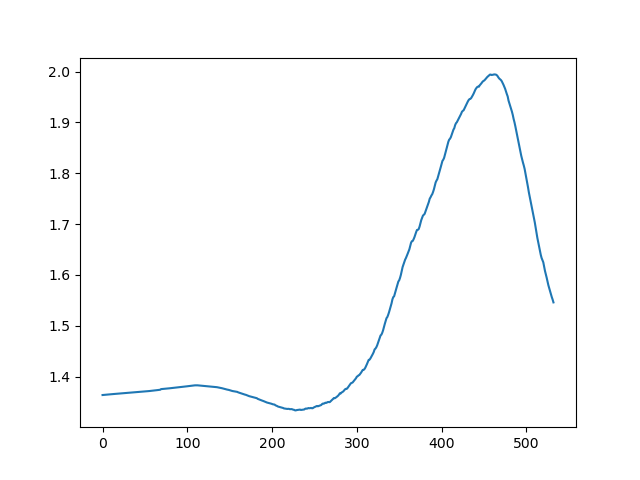

In [30]:
plt.figure()
plt.plot(np.array(O_dens_sd)[:-1]/np.array(O_dens_qd))

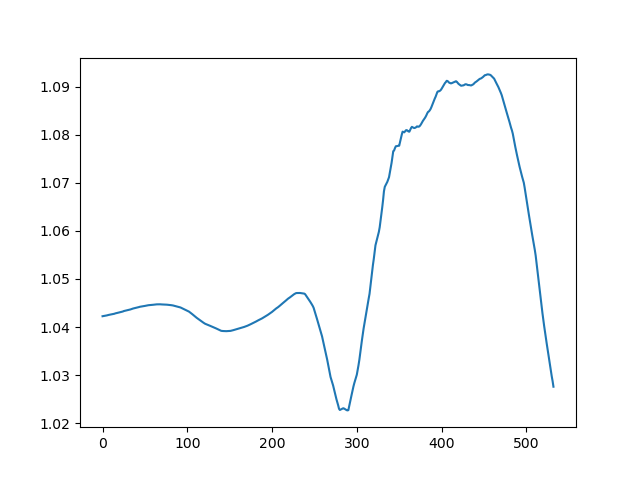

In [31]:
plt.figure()
plt.plot(np.array(Data_GITM_sd['Temperature'])[:-1]/np.array(Data_GITM_qd['Temperature']))

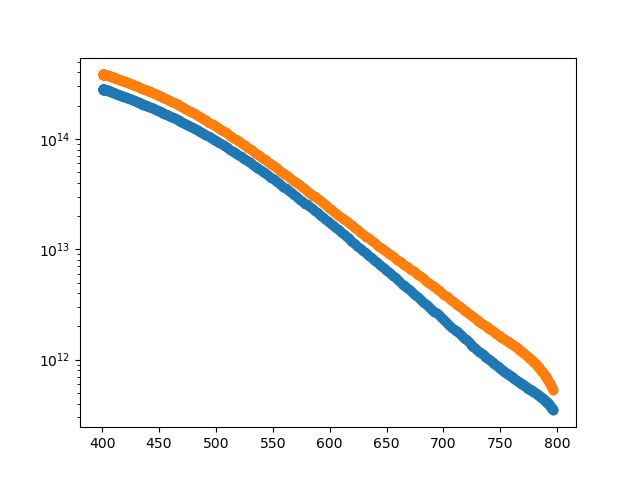

In [32]:

plt.figure()
plt.scatter(df_qd.altitude,np.array(O_dens_qd))
plt.scatter(df_sd.altitude,np.array(O_dens_sd))
plt.yscale('log')

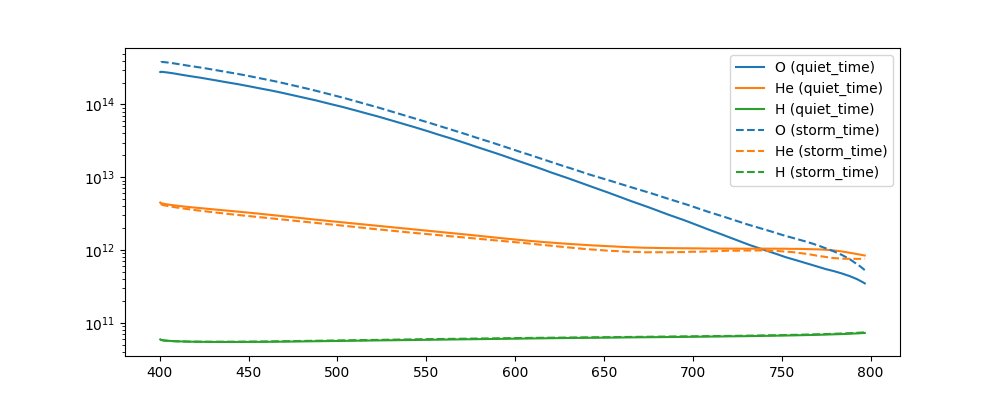

In [46]:
fig,ax = plt.subplots(1,1,figsize=[10,4],sharex=True,dpi=100)

ax.plot(df_qd['altitude'],O_dens_qd,c='tab:blue',ls='-',label='O (quiet_time)')
ax.plot(df_qd['altitude'],Data_GITM_qd['He'],c='tab:orange',ls='-',label='He (quiet_time)')
ax.plot(df_qd['altitude'],Data_GITM_qd['H'],c='tab:green',ls='-',label='H (quiet_time)')

ax.plot(df_sd['altitude'],O_dens_sd,c='tab:blue',ls='--',label='O (storm_time)')
ax.plot(df_sd['altitude'],Data_GITM_sd['He'],c='tab:orange',ls='--',label='He (storm_time)')
ax.plot(df_sd['altitude'],Data_GITM_sd['H'],c='tab:green',ls='--',label='H (storm_time)')

plt.yscale('log')
plt.legend()
# plt.grid(which='both')

In [39]:
np.max(Data_GITM_qd['H']),np.min(Data_GITM_qd['H'])

(72305749087.25352, 54317294017.09259)

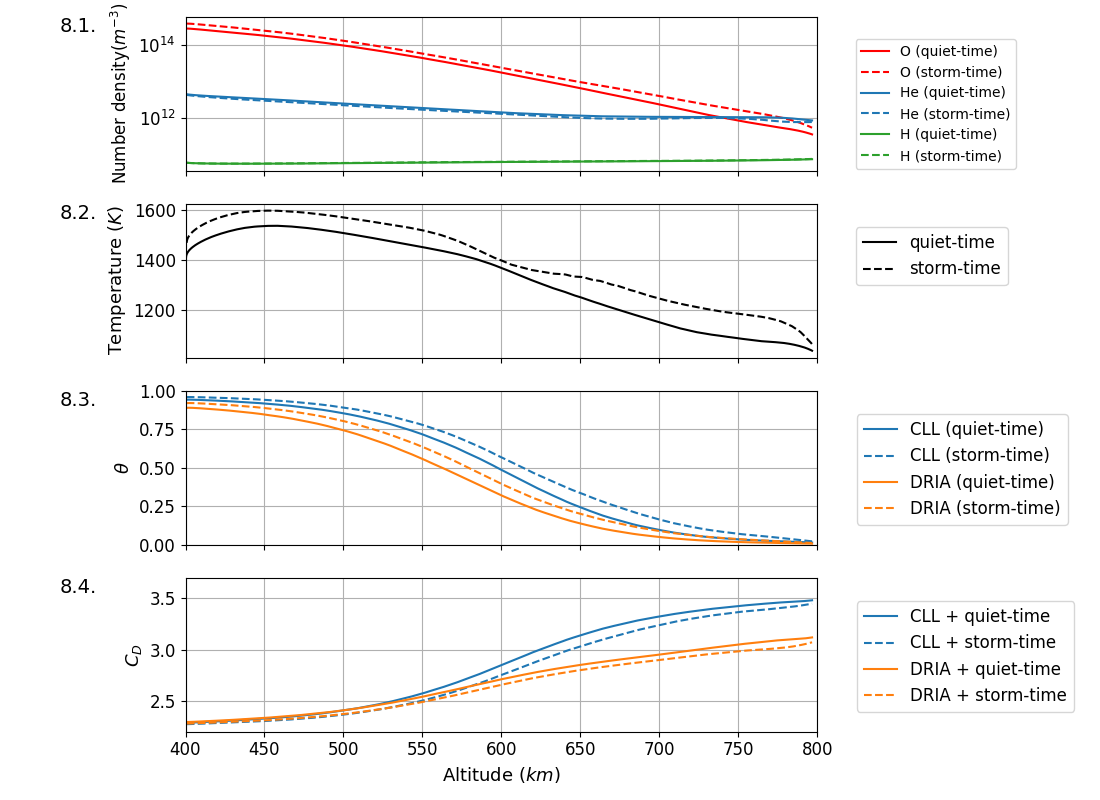

In [44]:
fig,ax = plt.subplots(4,1,figsize=[11,8],sharex=True)

ax[0].plot(df_qd['altitude'],O_dens_qd,label='O (quiet-time)',c='r',ls='-')
ax[0].plot(df_sd['altitude'],O_dens_sd,label='O (storm-time)',c='r',ls='--')
ax[0].plot(df_qd['altitude'],Data_GITM_qd['He'],label='He (quiet-time)',c='tab:blue',ls='-')
ax[0].plot(df_sd['altitude'],Data_GITM_sd['He'],label='He (storm-time)',c='tab:blue',ls='--')
ax[0].plot(df_qd['altitude'],Data_GITM_qd['H'],label='H (quiet-time)',c='tab:green',ls='-')
ax[0].plot(df_sd['altitude'],Data_GITM_sd['H'],label='H (storm-time)',c='tab:green',ls='--')
ax[0].set_ylabel(r'Number density($m^{-3}$)',fontsize=12)
ax[0].legend(fontsize=10,bbox_to_anchor = (1.05, 0.9))
# ax[0].set_ylim([0,1])
ax[0].set_xlim([400,800])
ax[0].grid()
ax[0].set_yscale('log')
ax[0].text(-0.2, 0.9, "8.1.", transform=ax[0].transAxes, fontsize=14, color='k')
ax[0].tick_params(labelsize=12)


ax[1].plot(Data_GITM_qd['alt']/1000,Data_GITM_qd['Temperature'],label='quiet-time',c='k',ls='-')
ax[1].plot(Data_GITM_sd['alt']/1000,Data_GITM_sd['Temperature'],label='storm-time',c='k',ls='--')
ax[1].set_ylabel(r'Temperature ($K$)',fontsize=13)
ax[1].legend(fontsize=12,bbox_to_anchor = (1.315, 0.9))
ax[1].set_xlim([400,800])
ax[1].grid()
ax[1].text(-0.2, 0.9, "8.2.", transform=ax[1].transAxes, fontsize=14, color='k')
ax[1].tick_params(labelsize=12)

ax[2].plot(df_qd['altitude'],theta_CLL_qd,'-',label='CLL (quiet-time)',c='tab:blue')
ax[2].plot(df_sd['altitude'],theta_CLL_sd,'--',label='CLL (storm-time)',c='tab:blue')
ax[2].plot(df_qd['altitude'],theta_DRIA_qd,'-',label='DRIA (quiet-time)',c='tab:orange')
ax[2].plot(df_sd['altitude'],theta_DRIA_sd,'--',label='DRIA (storm-time)',c='tab:orange')
ax[2].legend(fontsize=12,bbox_to_anchor = (1.05, 0.9))
ax[2].set_xlim([400,800])
ax[2].set_ylim([0,1])
ax[2].grid()
ax[2].set_ylabel(r'$\theta$',fontsize=13)
ax[2].text(-0.2, 0.9, "8.3.", transform=ax[2].transAxes, fontsize=14, color='k')
ax[2].tick_params(labelsize=12)

ax[3].plot(df_qd['altitude'],CD_GITM_CLL_qd['C_D'],'-',label='CLL + quiet-time',c='tab:blue')
ax[3].plot(df_sd['altitude'],CD_GITM_CLL_sd['C_D'],'--',label='CLL + storm-time',c='tab:blue')
ax[3].plot(df_qd['altitude'],CD_GITM_DRIA_qd['C_D'],'-',label='DRIA + quiet-time',c='tab:orange')
ax[3].plot(df_sd['altitude'],CD_GITM_DRIA_sd['C_D'],'--',label='DRIA + storm-time',c='tab:orange')
ax[3].set_ylabel(r'$C_{D}$',fontsize=13)
ax[3].legend(fontsize=12,bbox_to_anchor = (1.05, 0.9))
ax[3].set_xlim([400,800])
ax[3].set_yticks([2.5,3,3.5])
ax[3].set_ylim([2.2,3.7])
ax[3].grid()
ax[3].set_xlabel(r'Altitude ($km$)',fontsize=13)
ax[3].text(-0.2, 0.9, "8.4.", transform=ax[3].transAxes, fontsize=14, color='k')
ax[3].tick_params(labelsize=12)

plt.tight_layout()
filepath = "C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\plots\\"
# filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/plots/'
os.chdir(filepath);
filename = "CNOFS_CD_sens_4.jpg";
plt.savefig(filename,format='jpg',dpi=1200)
plt.show()
# ax[1].plot(CNOFS_Data['altitude'][idx_qd],Data_GITM['Temperature'][idx_qd],label='quiet-time')
# ax[1].plot(CNOFS_Data['altitude'][idx_sd],Data_GITM['Temperature'][idx_sd],label='storm-time')
# ax[1].set_ylabel('Temperature')
# ax[1].legend()

# ax[2].plot(CNOFS_Data['altitude'][idx_qd],CD_GITM_CLL_qd['C_D'],label='quiet-time')
# ax[2].plot(CNOFS_Data['altitude'][idx_sd],CD_GITM_CLL_sd['C_D'],label='storm-time')
# ax[2].set_ylabel('$C_D$')
# ax[2].legend()


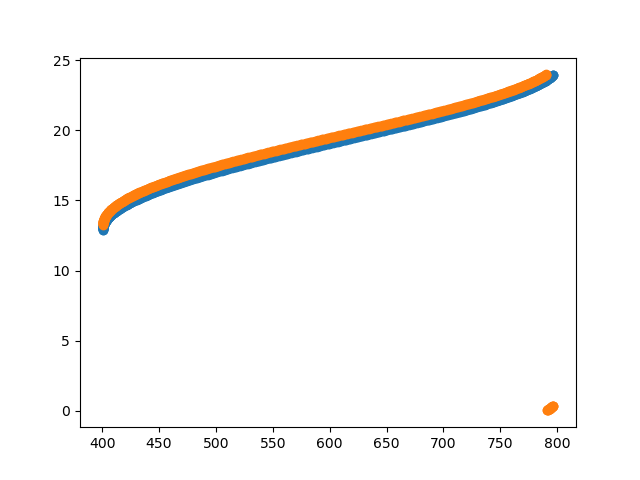

In [34]:
plt.figure()
plt.plot(df_qd.altitude,df_qd['slt'],'o')
plt.plot(df_sd.altitude,df_sd['slt'],'o')

In [38]:
3.52/3.15

1.1174603174603175

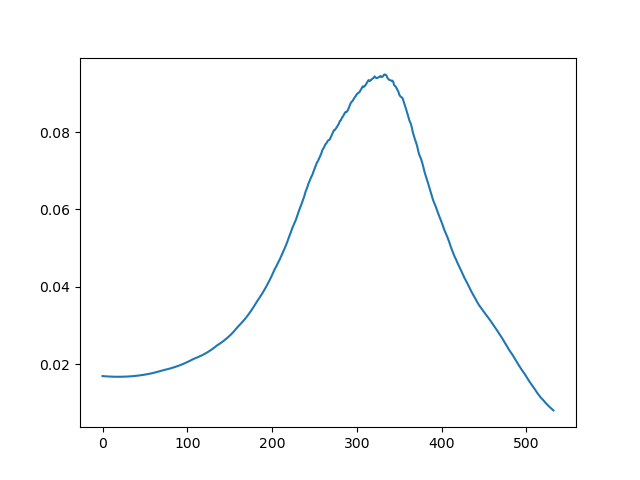

In [36]:
plt.figure()
plt.plot(np.array(theta_CLL_sd)[:-1] - np.array(theta_CLL_qd))

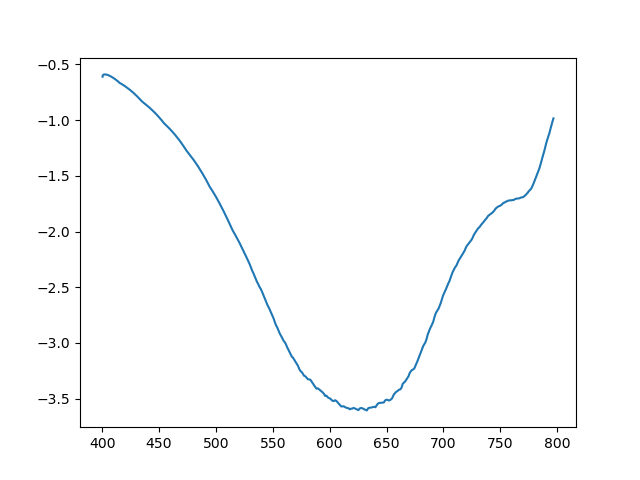

In [37]:
plt.figure()
plt.plot(df_qd.altitude,(np.array(CD_GITM_CLL_sd['C_D'][:-1])-np.array(CD_GITM_CLL_qd['C_D']))*100/np.array(CD_GITM_CLL_qd['C_D']))

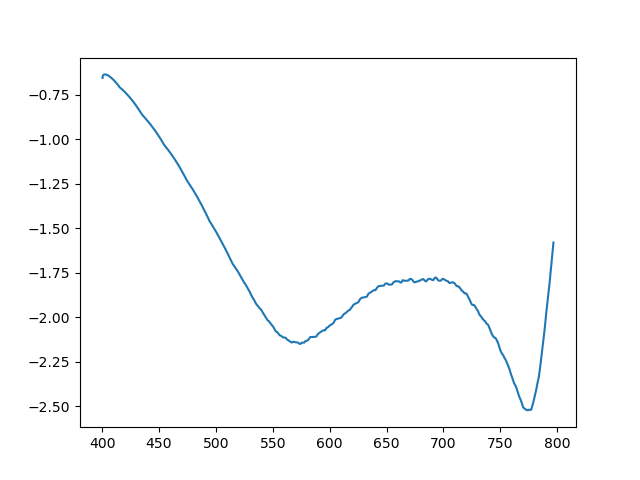

In [39]:
plt.figure()
plt.plot(df_qd.altitude,(np.array(CD_GITM_DRIA_sd['C_D'][:-1])-np.array(CD_GITM_DRIA_qd['C_D']))*100/np.array(CD_GITM_DRIA_qd['C_D']))

C:\Users\soumy\AppData\Local\Temp\ipykernel_8384\270356182.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


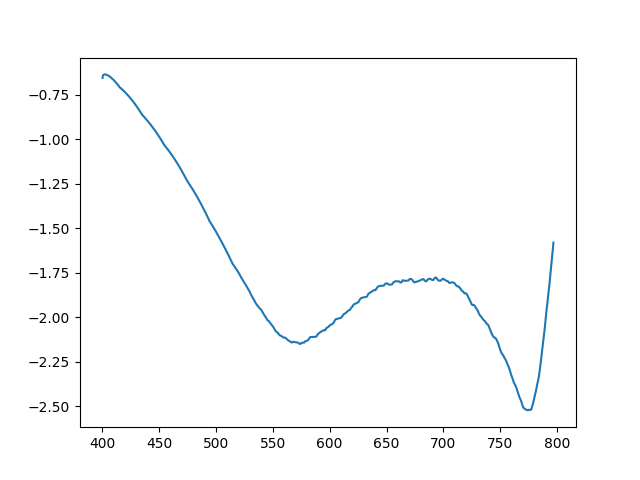

In [50]:
plt.figure()
plt.plot(df_qd.altitude,(np.array(CD_GITM_DRIA_sd['C_D'][:-1])-np.array(CD_GITM_DRIA_qd['C_D']))*100/np.array(CD_GITM_DRIA_qd['C_D']))

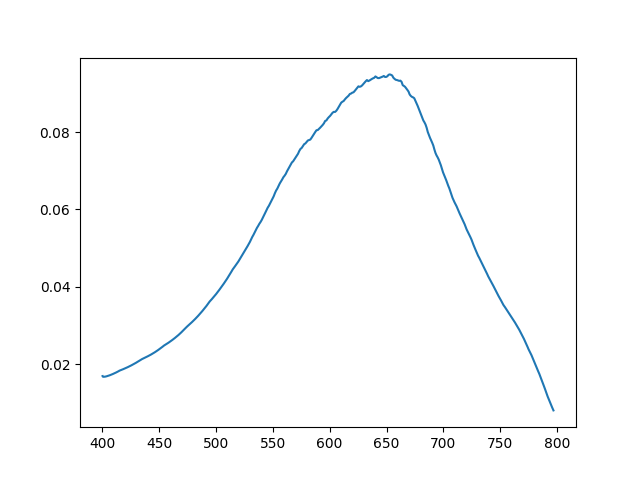

In [45]:
plt.figure()
plt.plot(df_qd.altitude,np.array(theta_CLL_sd)[:-1]-np.array(theta_CLL_qd))

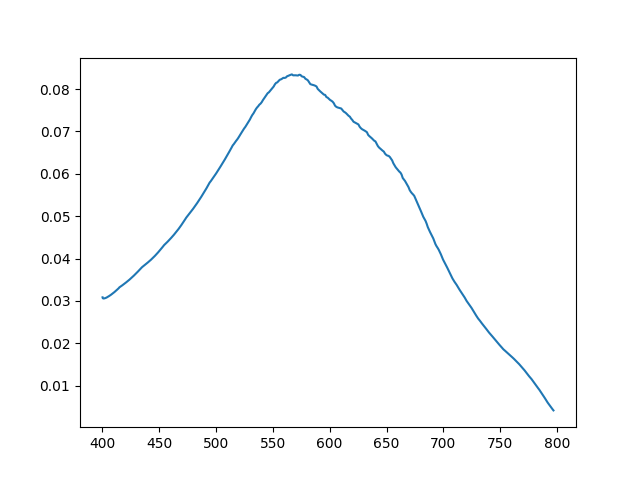

In [46]:
plt.figure()
plt.plot(df_qd.altitude,np.array(theta_DRIA_sd)[:-1]-np.array(theta_DRIA_qd))